In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 92)
(734160, 1)
validation
(101248, 92)
(101248, 1)
test
(100432, 92)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 92)]              0         


 dense (Dense)               (None, 1024)              95232     


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 784385 (2.99 MB)


Trainable params: 784385 (2.99 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:42 - loss: 0.1704 - STD: 3.4025e-05 - MAE: 0.4014

 7/74 [=>............................] - ETA: 0s - loss: 0.0431 - STD: 4.5857e-05 - MAE: 0.1575  

12/74 [===>..........................] - ETA: 0s - loss: 0.0367 - STD: 2.9892e-05 - MAE: 0.1490

18/74 [======>.......................] - ETA: 0s - loss: 0.0325 - STD: 2.1327e-05 - MAE: 0.1408

23/74 [========>.....................] - ETA: 0s - loss: 0.0285 - STD: 1.7836e-05 - MAE: 0.1291

28/74 [==========>...................] - ETA: 0s - loss: 0.0252 - STD: 1.5734e-05 - MAE: 0.1205

33/74 [============>.................] - ETA: 0s - loss: 0.0232 - STD: 1.4258e-05 - MAE: 0.1162

38/74 [==============>...............] - ETA: 0s - loss: 0.0214 - STD: 1.3134e-05 - MAE: 0.1112

44/74 [================>.............] - ETA: 0s - loss: 0.0198 - STD: 1.2106e-05 - MAE: 0.1061

50/74 [===================>..........] - ETA: 0s - loss: 0.0186 - STD: 1.1391e-05 - MAE: 0.1023

56/74 [=====================>........] - ETA: 0s - loss: 0.0176 - STD: 1.0929e-05 - MAE: 0.0995

61/74 [=======================>......] - ETA: 0s - loss: 0.0169 - STD: 1.0660e-05 - MAE: 0.0977

67/74 [==========================>...] - ETA: 0s - loss: 0.0162 - STD: 1.0411e-05 - MAE: 0.0957

72/74 [============================>.] - ETA: 0s - loss: 0.0157 - STD: 1.0264e-05 - MAE: 0.0943

74/74 [==============================] - ETA: 0s - loss: 0.0156 - STD: 1.0222e-05 - MAE: 0.0937

74/74 [==============================] - 3s 28ms/step - loss: 0.0156 - STD: 1.0222e-05 - MAE: 0.0937 - val_loss: 0.0086 - val_STD: 7.0758e-06 - val_MAE: 0.0715


Epoch 2/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0092 - STD: 8.9589e-06 - MAE: 0.0754

 6/74 [=>............................] - ETA: 0s - loss: 0.0091 - STD: 9.2620e-06 - MAE: 0.0753

12/74 [===>..........................] - ETA: 0s - loss: 0.0091 - STD: 9.6488e-06 - MAE: 0.0754

18/74 [======>.......................] - ETA: 0s - loss: 0.0092 - STD: 9.9710e-06 - MAE: 0.0754

24/74 [========>.....................] - ETA: 0s - loss: 0.0092 - STD: 1.0315e-05 - MAE: 0.0754

30/74 [===========>..................] - ETA: 0s - loss: 0.0092 - STD: 1.0706e-05 - MAE: 0.0755

36/74 [=============>................] - ETA: 0s - loss: 0.0092 - STD: 1.1116e-05 - MAE: 0.0756

42/74 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 1.1529e-05 - MAE: 0.0755

48/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 1.1957e-05 - MAE: 0.0755

54/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 1.2396e-05 - MAE: 0.0755

59/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 1.2781e-05 - MAE: 0.0755

65/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 1.3253e-05 - MAE: 0.0754

71/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 1.3740e-05 - MAE: 0.0754

74/74 [==============================] - 1s 11ms/step - loss: 0.0092 - STD: 1.3992e-05 - MAE: 0.0755 - val_loss: 0.0086 - val_STD: 1.6187e-05 - val_MAE: 0.0716


Epoch 3/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0090 - STD: 2.0776e-05 - MAE: 0.0744

 7/74 [=>............................] - ETA: 0s - loss: 0.0091 - STD: 2.1009e-05 - MAE: 0.0749

12/74 [===>..........................] - ETA: 0s - loss: 0.0091 - STD: 2.1481e-05 - MAE: 0.0751

17/74 [=====>........................] - ETA: 0s - loss: 0.0092 - STD: 2.2026e-05 - MAE: 0.0753

23/74 [========>.....................] - ETA: 0s - loss: 0.0092 - STD: 2.2756e-05 - MAE: 0.0753

29/74 [==========>...................] - ETA: 0s - loss: 0.0092 - STD: 2.3484e-05 - MAE: 0.0753

34/74 [============>.................] - ETA: 0s - loss: 0.0092 - STD: 2.4121e-05 - MAE: 0.0753

39/74 [==============>...............] - ETA: 0s - loss: 0.0092 - STD: 2.4780e-05 - MAE: 0.0754

44/74 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 2.5468e-05 - MAE: 0.0754

50/74 [===================>..........] - ETA: 0s - loss: 0.0092 - STD: 2.6325e-05 - MAE: 0.0754

56/74 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 2.7189e-05 - MAE: 0.0754

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 2.8100e-05 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 2.9090e-05 - MAE: 0.0754

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 3.0137e-05 - MAE: 0.0754

74/74 [==============================] - 1s 11ms/step - loss: 0.0092 - STD: 3.0137e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 3.4692e-05 - val_MAE: 0.0716


Epoch 4/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0092 - STD: 4.3138e-05 - MAE: 0.0754

 6/74 [=>............................] - ETA: 0s - loss: 0.0093 - STD: 4.4580e-05 - MAE: 0.0756

12/74 [===>..........................] - ETA: 0s - loss: 0.0092 - STD: 4.6191e-05 - MAE: 0.0755

18/74 [======>.......................] - ETA: 0s - loss: 0.0092 - STD: 4.7974e-05 - MAE: 0.0754

24/74 [========>.....................] - ETA: 0s - loss: 0.0092 - STD: 4.9603e-05 - MAE: 0.0754

29/74 [==========>...................] - ETA: 0s - loss: 0.0092 - STD: 5.1197e-05 - MAE: 0.0754

35/74 [=============>................] - ETA: 0s - loss: 0.0092 - STD: 5.3124e-05 - MAE: 0.0754

41/74 [===============>..............] - ETA: 0s - loss: 0.0092 - STD: 5.5138e-05 - MAE: 0.0754

47/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 5.7435e-05 - MAE: 0.0755

52/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 5.9357e-05 - MAE: 0.0755

57/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 6.1442e-05 - MAE: 0.0755

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 6.4212e-05 - MAE: 0.0755

69/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 6.7096e-05 - MAE: 0.0754

74/74 [==============================] - 1s 11ms/step - loss: 0.0092 - STD: 6.9679e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 8.8571e-05 - val_MAE: 0.0716


Epoch 5/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0093 - STD: 1.1116e-04 - MAE: 0.0756

 6/74 [=>............................] - ETA: 0s - loss: 0.0093 - STD: 1.1508e-04 - MAE: 0.0754

12/74 [===>..........................] - ETA: 0s - loss: 0.0092 - STD: 1.2063e-04 - MAE: 0.0754

17/74 [=====>........................] - ETA: 0s - loss: 0.0092 - STD: 1.2603e-04 - MAE: 0.0755

22/74 [=======>......................] - ETA: 0s - loss: 0.0092 - STD: 1.3120e-04 - MAE: 0.0755

28/74 [==========>...................] - ETA: 0s - loss: 0.0092 - STD: 1.3822e-04 - MAE: 0.0755

34/74 [============>.................] - ETA: 0s - loss: 0.0092 - STD: 1.4586e-04 - MAE: 0.0754

39/74 [==============>...............] - ETA: 0s - loss: 0.0092 - STD: 1.5288e-04 - MAE: 0.0754

44/74 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 1.6058e-04 - MAE: 0.0754

50/74 [===================>..........] - ETA: 0s - loss: 0.0092 - STD: 1.7051e-04 - MAE: 0.0754

56/74 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 1.8172e-04 - MAE: 0.0754

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.9418e-04 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 2.0850e-04 - MAE: 0.0754

73/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 2.2143e-04 - MAE: 0.0754

74/74 [==============================] - 1s 11ms/step - loss: 0.0092 - STD: 2.2416e-04 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 3.4997e-04 - val_MAE: 0.0713


Epoch 6/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0092 - STD: 4.3553e-04 - MAE: 0.0749

 7/74 [=>............................] - ETA: 0s - loss: 0.0092 - STD: 4.7469e-04 - MAE: 0.0753

12/74 [===>..........................] - ETA: 0s - loss: 0.0092 - STD: 5.0586e-04 - MAE: 0.0755

17/74 [=====>........................] - ETA: 0s - loss: 0.0092 - STD: 5.3762e-04 - MAE: 0.0753

22/74 [=======>......................] - ETA: 0s - loss: 0.0092 - STD: 5.7614e-04 - MAE: 0.0754

27/74 [=========>....................] - ETA: 0s - loss: 0.0092 - STD: 6.1952e-04 - MAE: 0.0754

33/74 [============>.................] - ETA: 0s - loss: 0.0092 - STD: 6.7786e-04 - MAE: 0.0753

38/74 [==============>...............] - ETA: 0s - loss: 0.0092 - STD: 7.3498e-04 - MAE: 0.0753

43/74 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 7.9894e-04 - MAE: 0.0753

48/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 8.7530e-04 - MAE: 0.0753

54/74 [====================>.........] - ETA: 0s - loss: 0.0091 - STD: 9.7989e-04 - MAE: 0.0752

60/74 [=======================>......] - ETA: 0s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0752    

66/74 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 0.0013 - MAE: 0.0751

71/74 [===========================>..] - ETA: 0s - loss: 0.0091 - STD: 0.0014 - MAE: 0.0751

74/74 [==============================] - 1s 11ms/step - loss: 0.0091 - STD: 0.0015 - MAE: 0.0751 - val_loss: 0.0083 - val_STD: 0.0034 - val_MAE: 0.0707


Epoch 7/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0090 - STD: 0.0041 - MAE: 0.0751

 6/74 [=>............................] - ETA: 0s - loss: 0.0089 - STD: 0.0046 - MAE: 0.0744

11/74 [===>..........................] - ETA: 0s - loss: 0.0088 - STD: 0.0051 - MAE: 0.0741

17/74 [=====>........................] - ETA: 0s - loss: 0.0088 - STD: 0.0057 - MAE: 0.0740

23/74 [========>.....................] - ETA: 0s - loss: 0.0088 - STD: 0.0065 - MAE: 0.0740

29/74 [==========>...................] - ETA: 0s - loss: 0.0087 - STD: 0.0074 - MAE: 0.0738

35/74 [=============>................] - ETA: 0s - loss: 0.0087 - STD: 0.0084 - MAE: 0.0737

40/74 [===============>..............] - ETA: 0s - loss: 0.0087 - STD: 0.0094 - MAE: 0.0736

46/74 [=================>............] - ETA: 0s - loss: 0.0086 - STD: 0.0106 - MAE: 0.0733

52/74 [====================>.........] - ETA: 0s - loss: 0.0085 - STD: 0.0118 - MAE: 0.0730

58/74 [======================>.......] - ETA: 0s - loss: 0.0085 - STD: 0.0131 - MAE: 0.0727

63/74 [========================>.....] - ETA: 0s - loss: 0.0084 - STD: 0.0143 - MAE: 0.0725

69/74 [==========================>...] - ETA: 0s - loss: 0.0084 - STD: 0.0156 - MAE: 0.0722

74/74 [==============================] - 1s 11ms/step - loss: 0.0083 - STD: 0.0167 - MAE: 0.0720 - val_loss: 0.0069 - val_STD: 0.0220 - val_MAE: 0.0620


Epoch 8/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0077 - STD: 0.0325 - MAE: 0.0682

 6/74 [=>............................] - ETA: 0s - loss: 0.0076 - STD: 0.0333 - MAE: 0.0684

11/74 [===>..........................] - ETA: 0s - loss: 0.0075 - STD: 0.0341 - MAE: 0.0683

17/74 [=====>........................] - ETA: 0s - loss: 0.0075 - STD: 0.0349 - MAE: 0.0682

22/74 [=======>......................] - ETA: 0s - loss: 0.0075 - STD: 0.0353 - MAE: 0.0680

27/74 [=========>....................] - ETA: 0s - loss: 0.0075 - STD: 0.0358 - MAE: 0.0679

32/74 [===========>..................] - ETA: 0s - loss: 0.0075 - STD: 0.0362 - MAE: 0.0678

37/74 [==============>...............] - ETA: 0s - loss: 0.0075 - STD: 0.0366 - MAE: 0.0678

42/74 [================>.............] - ETA: 0s - loss: 0.0075 - STD: 0.0369 - MAE: 0.0676

48/74 [==================>...........] - ETA: 0s - loss: 0.0075 - STD: 0.0373 - MAE: 0.0676

54/74 [====================>.........] - ETA: 0s - loss: 0.0075 - STD: 0.0376 - MAE: 0.0676

60/74 [=======================>......] - ETA: 0s - loss: 0.0074 - STD: 0.0379 - MAE: 0.0675

66/74 [=========================>....] - ETA: 0s - loss: 0.0074 - STD: 0.0381 - MAE: 0.0675

72/74 [============================>.] - ETA: 0s - loss: 0.0074 - STD: 0.0383 - MAE: 0.0674

74/74 [==============================] - 1s 11ms/step - loss: 0.0074 - STD: 0.0383 - MAE: 0.0674 - val_loss: 0.0065 - val_STD: 0.0284 - val_MAE: 0.0595


Epoch 9/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0075 - STD: 0.0412 - MAE: 0.0677

 6/74 [=>............................] - ETA: 0s - loss: 0.0073 - STD: 0.0411 - MAE: 0.0668

11/74 [===>..........................] - ETA: 0s - loss: 0.0073 - STD: 0.0409 - MAE: 0.0667

16/74 [=====>........................] - ETA: 0s - loss: 0.0073 - STD: 0.0410 - MAE: 0.0667

22/74 [=======>......................] - ETA: 0s - loss: 0.0073 - STD: 0.0412 - MAE: 0.0668

28/74 [==========>...................] - ETA: 0s - loss: 0.0073 - STD: 0.0413 - MAE: 0.0668

33/74 [============>.................] - ETA: 0s - loss: 0.0073 - STD: 0.0413 - MAE: 0.0667

38/74 [==============>...............] - ETA: 0s - loss: 0.0073 - STD: 0.0413 - MAE: 0.0667

43/74 [================>.............] - ETA: 0s - loss: 0.0073 - STD: 0.0414 - MAE: 0.0667

49/74 [==================>...........] - ETA: 0s - loss: 0.0073 - STD: 0.0415 - MAE: 0.0667

55/74 [=====================>........] - ETA: 0s - loss: 0.0073 - STD: 0.0416 - MAE: 0.0666

60/74 [=======================>......] - ETA: 0s - loss: 0.0073 - STD: 0.0416 - MAE: 0.0666

65/74 [=========================>....] - ETA: 0s - loss: 0.0073 - STD: 0.0417 - MAE: 0.0666

71/74 [===========================>..] - ETA: 0s - loss: 0.0073 - STD: 0.0417 - MAE: 0.0666

74/74 [==============================] - 1s 11ms/step - loss: 0.0073 - STD: 0.0417 - MAE: 0.0666 - val_loss: 0.0065 - val_STD: 0.0292 - val_MAE: 0.0591


Epoch 10/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0072 - STD: 0.0427 - MAE: 0.0658

 6/74 [=>............................] - ETA: 0s - loss: 0.0073 - STD: 0.0423 - MAE: 0.0660

11/74 [===>..........................] - ETA: 0s - loss: 0.0073 - STD: 0.0423 - MAE: 0.0662

17/74 [=====>........................] - ETA: 0s - loss: 0.0073 - STD: 0.0428 - MAE: 0.0663

23/74 [========>.....................] - ETA: 0s - loss: 0.0073 - STD: 0.0428 - MAE: 0.0664

28/74 [==========>...................] - ETA: 0s - loss: 0.0073 - STD: 0.0427 - MAE: 0.0663

34/74 [============>.................] - ETA: 0s - loss: 0.0073 - STD: 0.0428 - MAE: 0.0663

40/74 [===============>..............] - ETA: 0s - loss: 0.0073 - STD: 0.0429 - MAE: 0.0662

46/74 [=================>............] - ETA: 0s - loss: 0.0072 - STD: 0.0429 - MAE: 0.0661

51/74 [===================>..........] - ETA: 0s - loss: 0.0072 - STD: 0.0431 - MAE: 0.0661

57/74 [======================>.......] - ETA: 0s - loss: 0.0072 - STD: 0.0431 - MAE: 0.0661

63/74 [========================>.....] - ETA: 0s - loss: 0.0072 - STD: 0.0431 - MAE: 0.0660

69/74 [==========================>...] - ETA: 0s - loss: 0.0072 - STD: 0.0431 - MAE: 0.0660

74/74 [==============================] - 1s 11ms/step - loss: 0.0072 - STD: 0.0432 - MAE: 0.0659 - val_loss: 0.0064 - val_STD: 0.0310 - val_MAE: 0.0583


Epoch 11/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0071 - STD: 0.0444 - MAE: 0.0651

 6/74 [=>............................] - ETA: 0s - loss: 0.0071 - STD: 0.0448 - MAE: 0.0656

11/74 [===>..........................] - ETA: 0s - loss: 0.0072 - STD: 0.0444 - MAE: 0.0659

16/74 [=====>........................] - ETA: 0s - loss: 0.0072 - STD: 0.0441 - MAE: 0.0657

21/74 [=======>......................] - ETA: 0s - loss: 0.0072 - STD: 0.0442 - MAE: 0.0658

26/74 [=========>....................] - ETA: 0s - loss: 0.0072 - STD: 0.0442 - MAE: 0.0657

31/74 [===========>..................] - ETA: 0s - loss: 0.0071 - STD: 0.0442 - MAE: 0.0656

36/74 [=============>................] - ETA: 0s - loss: 0.0071 - STD: 0.0442 - MAE: 0.0655

41/74 [===============>..............] - ETA: 0s - loss: 0.0071 - STD: 0.0442 - MAE: 0.0656

46/74 [=================>............] - ETA: 0s - loss: 0.0071 - STD: 0.0442 - MAE: 0.0655

52/74 [====================>.........] - ETA: 0s - loss: 0.0071 - STD: 0.0442 - MAE: 0.0655

58/74 [======================>.......] - ETA: 0s - loss: 0.0071 - STD: 0.0442 - MAE: 0.0655

63/74 [========================>.....] - ETA: 0s - loss: 0.0071 - STD: 0.0442 - MAE: 0.0654

68/74 [==========================>...] - ETA: 0s - loss: 0.0071 - STD: 0.0443 - MAE: 0.0653

73/74 [============================>.] - ETA: 0s - loss: 0.0071 - STD: 0.0444 - MAE: 0.0653

74/74 [==============================] - 1s 12ms/step - loss: 0.0071 - STD: 0.0444 - MAE: 0.0653 - val_loss: 0.0062 - val_STD: 0.0317 - val_MAE: 0.0576


Epoch 12/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0070 - STD: 0.0443 - MAE: 0.0650

 6/74 [=>............................] - ETA: 0s - loss: 0.0070 - STD: 0.0441 - MAE: 0.0648

11/74 [===>..........................] - ETA: 0s - loss: 0.0070 - STD: 0.0445 - MAE: 0.0649

16/74 [=====>........................] - ETA: 0s - loss: 0.0070 - STD: 0.0448 - MAE: 0.0651

21/74 [=======>......................] - ETA: 0s - loss: 0.0070 - STD: 0.0451 - MAE: 0.0649

26/74 [=========>....................] - ETA: 0s - loss: 0.0070 - STD: 0.0451 - MAE: 0.0649

31/74 [===========>..................] - ETA: 0s - loss: 0.0070 - STD: 0.0452 - MAE: 0.0648

36/74 [=============>................] - ETA: 0s - loss: 0.0070 - STD: 0.0452 - MAE: 0.0647

41/74 [===============>..............] - ETA: 0s - loss: 0.0070 - STD: 0.0453 - MAE: 0.0646

46/74 [=================>............] - ETA: 0s - loss: 0.0070 - STD: 0.0453 - MAE: 0.0646

52/74 [====================>.........] - ETA: 0s - loss: 0.0070 - STD: 0.0453 - MAE: 0.0646

57/74 [======================>.......] - ETA: 0s - loss: 0.0070 - STD: 0.0454 - MAE: 0.0646

63/74 [========================>.....] - ETA: 0s - loss: 0.0070 - STD: 0.0454 - MAE: 0.0645

69/74 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.0454 - MAE: 0.0645

74/74 [==============================] - 1s 11ms/step - loss: 0.0070 - STD: 0.0455 - MAE: 0.0645 - val_loss: 0.0060 - val_STD: 0.0332 - val_MAE: 0.0567


Epoch 13/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0068 - STD: 0.0469 - MAE: 0.0644

 6/74 [=>............................] - ETA: 0s - loss: 0.0070 - STD: 0.0460 - MAE: 0.0644

12/74 [===>..........................] - ETA: 0s - loss: 0.0070 - STD: 0.0454 - MAE: 0.0644

17/74 [=====>........................] - ETA: 0s - loss: 0.0070 - STD: 0.0455 - MAE: 0.0645

22/74 [=======>......................] - ETA: 0s - loss: 0.0069 - STD: 0.0457 - MAE: 0.0644

27/74 [=========>....................] - ETA: 0s - loss: 0.0069 - STD: 0.0460 - MAE: 0.0643

32/74 [===========>..................] - ETA: 0s - loss: 0.0069 - STD: 0.0462 - MAE: 0.0643

37/74 [==============>...............] - ETA: 0s - loss: 0.0069 - STD: 0.0463 - MAE: 0.0643

42/74 [================>.............] - ETA: 0s - loss: 0.0069 - STD: 0.0463 - MAE: 0.0642

47/74 [==================>...........] - ETA: 0s - loss: 0.0069 - STD: 0.0464 - MAE: 0.0641

52/74 [====================>.........] - ETA: 0s - loss: 0.0069 - STD: 0.0465 - MAE: 0.0641

58/74 [======================>.......] - ETA: 0s - loss: 0.0069 - STD: 0.0466 - MAE: 0.0640

63/74 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0466 - MAE: 0.0640

68/74 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.0467 - MAE: 0.0640

74/74 [==============================] - ETA: 0s - loss: 0.0069 - STD: 0.0468 - MAE: 0.0640

74/74 [==============================] - 1s 11ms/step - loss: 0.0069 - STD: 0.0468 - MAE: 0.0640 - val_loss: 0.0062 - val_STD: 0.0333 - val_MAE: 0.0566


Epoch 14/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0067 - STD: 0.0461 - MAE: 0.0624

 7/74 [=>............................] - ETA: 0s - loss: 0.0067 - STD: 0.0468 - MAE: 0.0631

13/74 [====>.........................] - ETA: 0s - loss: 0.0068 - STD: 0.0471 - MAE: 0.0635

18/74 [======>.......................] - ETA: 0s - loss: 0.0068 - STD: 0.0474 - MAE: 0.0635

23/74 [========>.....................] - ETA: 0s - loss: 0.0068 - STD: 0.0476 - MAE: 0.0636

29/74 [==========>...................] - ETA: 0s - loss: 0.0068 - STD: 0.0477 - MAE: 0.0635

35/74 [=============>................] - ETA: 0s - loss: 0.0068 - STD: 0.0478 - MAE: 0.0635

40/74 [===============>..............] - ETA: 0s - loss: 0.0068 - STD: 0.0478 - MAE: 0.0635

45/74 [=================>............] - ETA: 0s - loss: 0.0068 - STD: 0.0479 - MAE: 0.0635

50/74 [===================>..........] - ETA: 0s - loss: 0.0068 - STD: 0.0479 - MAE: 0.0635

55/74 [=====================>........] - ETA: 0s - loss: 0.0068 - STD: 0.0479 - MAE: 0.0635

60/74 [=======================>......] - ETA: 0s - loss: 0.0068 - STD: 0.0479 - MAE: 0.0635

65/74 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0479 - MAE: 0.0635

70/74 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0480 - MAE: 0.0635

74/74 [==============================] - 1s 11ms/step - loss: 0.0068 - STD: 0.0481 - MAE: 0.0635 - val_loss: 0.0058 - val_STD: 0.0366 - val_MAE: 0.0561


Epoch 15/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0067 - STD: 0.0499 - MAE: 0.0640

 6/74 [=>............................] - ETA: 0s - loss: 0.0067 - STD: 0.0488 - MAE: 0.0631

12/74 [===>..........................] - ETA: 0s - loss: 0.0068 - STD: 0.0485 - MAE: 0.0634

17/74 [=====>........................] - ETA: 0s - loss: 0.0068 - STD: 0.0484 - MAE: 0.0635

22/74 [=======>......................] - ETA: 0s - loss: 0.0068 - STD: 0.0485 - MAE: 0.0635

27/74 [=========>....................] - ETA: 0s - loss: 0.0068 - STD: 0.0486 - MAE: 0.0635

32/74 [===========>..................] - ETA: 0s - loss: 0.0068 - STD: 0.0487 - MAE: 0.0634

37/74 [==============>...............] - ETA: 0s - loss: 0.0068 - STD: 0.0488 - MAE: 0.0634

42/74 [================>.............] - ETA: 0s - loss: 0.0068 - STD: 0.0488 - MAE: 0.0634

47/74 [==================>...........] - ETA: 0s - loss: 0.0068 - STD: 0.0488 - MAE: 0.0634

52/74 [====================>.........] - ETA: 0s - loss: 0.0068 - STD: 0.0488 - MAE: 0.0633

57/74 [======================>.......] - ETA: 0s - loss: 0.0068 - STD: 0.0489 - MAE: 0.0634

62/74 [========================>.....] - ETA: 0s - loss: 0.0068 - STD: 0.0488 - MAE: 0.0633

67/74 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0488 - MAE: 0.0633

72/74 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0488 - MAE: 0.0633

74/74 [==============================] - 1s 11ms/step - loss: 0.0068 - STD: 0.0489 - MAE: 0.0633 - val_loss: 0.0059 - val_STD: 0.0365 - val_MAE: 0.0559


Epoch 16/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0066 - STD: 0.0493 - MAE: 0.0626

 6/74 [=>............................] - ETA: 0s - loss: 0.0066 - STD: 0.0496 - MAE: 0.0626

12/74 [===>..........................] - ETA: 0s - loss: 0.0067 - STD: 0.0498 - MAE: 0.0633

17/74 [=====>........................] - ETA: 0s - loss: 0.0068 - STD: 0.0494 - MAE: 0.0633

22/74 [=======>......................] - ETA: 0s - loss: 0.0068 - STD: 0.0491 - MAE: 0.0633

27/74 [=========>....................] - ETA: 0s - loss: 0.0068 - STD: 0.0491 - MAE: 0.0634

32/74 [===========>..................] - ETA: 0s - loss: 0.0068 - STD: 0.0492 - MAE: 0.0633

37/74 [==============>...............] - ETA: 0s - loss: 0.0068 - STD: 0.0492 - MAE: 0.0633

42/74 [================>.............] - ETA: 0s - loss: 0.0068 - STD: 0.0492 - MAE: 0.0633

47/74 [==================>...........] - ETA: 0s - loss: 0.0068 - STD: 0.0492 - MAE: 0.0633

52/74 [====================>.........] - ETA: 0s - loss: 0.0068 - STD: 0.0492 - MAE: 0.0633

57/74 [======================>.......] - ETA: 0s - loss: 0.0068 - STD: 0.0492 - MAE: 0.0633

62/74 [========================>.....] - ETA: 0s - loss: 0.0068 - STD: 0.0492 - MAE: 0.0633

67/74 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0492 - MAE: 0.0633

72/74 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0493 - MAE: 0.0633

74/74 [==============================] - 1s 12ms/step - loss: 0.0068 - STD: 0.0493 - MAE: 0.0632 - val_loss: 0.0057 - val_STD: 0.0379 - val_MAE: 0.0560


Epoch 17/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0066 - STD: 0.0500 - MAE: 0.0634

 6/74 [=>............................] - ETA: 0s - loss: 0.0068 - STD: 0.0494 - MAE: 0.0631

11/74 [===>..........................] - ETA: 0s - loss: 0.0068 - STD: 0.0496 - MAE: 0.0634

16/74 [=====>........................] - ETA: 0s - loss: 0.0068 - STD: 0.0495 - MAE: 0.0633

21/74 [=======>......................] - ETA: 0s - loss: 0.0068 - STD: 0.0494 - MAE: 0.0633

26/74 [=========>....................] - ETA: 0s - loss: 0.0068 - STD: 0.0496 - MAE: 0.0633

31/74 [===========>..................] - ETA: 0s - loss: 0.0067 - STD: 0.0495 - MAE: 0.0632

37/74 [==============>...............] - ETA: 0s - loss: 0.0067 - STD: 0.0495 - MAE: 0.0631

42/74 [================>.............] - ETA: 0s - loss: 0.0067 - STD: 0.0495 - MAE: 0.0632

47/74 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0495 - MAE: 0.0631

52/74 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.0496 - MAE: 0.0631

57/74 [======================>.......] - ETA: 0s - loss: 0.0067 - STD: 0.0496 - MAE: 0.0630

62/74 [========================>.....] - ETA: 0s - loss: 0.0067 - STD: 0.0496 - MAE: 0.0630

67/74 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0496 - MAE: 0.0630

72/74 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.0497 - MAE: 0.0629

74/74 [==============================] - 1s 12ms/step - loss: 0.0067 - STD: 0.0497 - MAE: 0.0629 - val_loss: 0.0058 - val_STD: 0.0384 - val_MAE: 0.0557


Epoch 18/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0069 - STD: 0.0504 - MAE: 0.0639

 6/74 [=>............................] - ETA: 0s - loss: 0.0068 - STD: 0.0501 - MAE: 0.0633

11/74 [===>..........................] - ETA: 0s - loss: 0.0067 - STD: 0.0500 - MAE: 0.0632

16/74 [=====>........................] - ETA: 0s - loss: 0.0067 - STD: 0.0499 - MAE: 0.0631

21/74 [=======>......................] - ETA: 0s - loss: 0.0067 - STD: 0.0499 - MAE: 0.0631

27/74 [=========>....................] - ETA: 0s - loss: 0.0067 - STD: 0.0500 - MAE: 0.0630

32/74 [===========>..................] - ETA: 0s - loss: 0.0067 - STD: 0.0499 - MAE: 0.0630

37/74 [==============>...............] - ETA: 0s - loss: 0.0067 - STD: 0.0500 - MAE: 0.0629

42/74 [================>.............] - ETA: 0s - loss: 0.0067 - STD: 0.0500 - MAE: 0.0630

47/74 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0499 - MAE: 0.0630

52/74 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.0499 - MAE: 0.0630

57/74 [======================>.......] - ETA: 0s - loss: 0.0067 - STD: 0.0499 - MAE: 0.0630

62/74 [========================>.....] - ETA: 0s - loss: 0.0067 - STD: 0.0499 - MAE: 0.0630

67/74 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0499 - MAE: 0.0629

72/74 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.0500 - MAE: 0.0629

74/74 [==============================] - 1s 12ms/step - loss: 0.0067 - STD: 0.0500 - MAE: 0.0629 - val_loss: 0.0059 - val_STD: 0.0379 - val_MAE: 0.0555


Epoch 19/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0066 - STD: 0.0505 - MAE: 0.0625

 6/74 [=>............................] - ETA: 0s - loss: 0.0066 - STD: 0.0502 - MAE: 0.0627

11/74 [===>..........................] - ETA: 0s - loss: 0.0066 - STD: 0.0502 - MAE: 0.0625

16/74 [=====>........................] - ETA: 0s - loss: 0.0066 - STD: 0.0501 - MAE: 0.0624

21/74 [=======>......................] - ETA: 0s - loss: 0.0066 - STD: 0.0502 - MAE: 0.0625

26/74 [=========>....................] - ETA: 0s - loss: 0.0066 - STD: 0.0502 - MAE: 0.0625

31/74 [===========>..................] - ETA: 0s - loss: 0.0066 - STD: 0.0502 - MAE: 0.0625

36/74 [=============>................] - ETA: 0s - loss: 0.0066 - STD: 0.0502 - MAE: 0.0625

41/74 [===============>..............] - ETA: 0s - loss: 0.0066 - STD: 0.0503 - MAE: 0.0626

46/74 [=================>............] - ETA: 0s - loss: 0.0066 - STD: 0.0502 - MAE: 0.0626

51/74 [===================>..........] - ETA: 0s - loss: 0.0066 - STD: 0.0503 - MAE: 0.0626

56/74 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.0503 - MAE: 0.0626

61/74 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0502 - MAE: 0.0626

66/74 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0503 - MAE: 0.0626

71/74 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0503 - MAE: 0.0626

74/74 [==============================] - 1s 12ms/step - loss: 0.0066 - STD: 0.0503 - MAE: 0.0626 - val_loss: 0.0058 - val_STD: 0.0391 - val_MAE: 0.0555


Epoch 20/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0068 - STD: 0.0507 - MAE: 0.0636

 6/74 [=>............................] - ETA: 0s - loss: 0.0067 - STD: 0.0505 - MAE: 0.0629

11/74 [===>..........................] - ETA: 0s - loss: 0.0066 - STD: 0.0508 - MAE: 0.0625

16/74 [=====>........................] - ETA: 0s - loss: 0.0066 - STD: 0.0508 - MAE: 0.0625

21/74 [=======>......................] - ETA: 0s - loss: 0.0066 - STD: 0.0507 - MAE: 0.0625

27/74 [=========>....................] - ETA: 0s - loss: 0.0066 - STD: 0.0506 - MAE: 0.0626

32/74 [===========>..................] - ETA: 0s - loss: 0.0066 - STD: 0.0505 - MAE: 0.0627

37/74 [==============>...............] - ETA: 0s - loss: 0.0066 - STD: 0.0504 - MAE: 0.0626

42/74 [================>.............] - ETA: 0s - loss: 0.0066 - STD: 0.0505 - MAE: 0.0626

47/74 [==================>...........] - ETA: 0s - loss: 0.0066 - STD: 0.0506 - MAE: 0.0626

52/74 [====================>.........] - ETA: 0s - loss: 0.0066 - STD: 0.0506 - MAE: 0.0626

57/74 [======================>.......] - ETA: 0s - loss: 0.0066 - STD: 0.0506 - MAE: 0.0626

62/74 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0505 - MAE: 0.0626

67/74 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.0505 - MAE: 0.0626

72/74 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0505 - MAE: 0.0626

74/74 [==============================] - 1s 11ms/step - loss: 0.0066 - STD: 0.0505 - MAE: 0.0626 - val_loss: 0.0059 - val_STD: 0.0386 - val_MAE: 0.0554


Epoch 21/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0065 - STD: 0.0505 - MAE: 0.0621

 6/74 [=>............................] - ETA: 0s - loss: 0.0066 - STD: 0.0507 - MAE: 0.0624

11/74 [===>..........................] - ETA: 0s - loss: 0.0066 - STD: 0.0508 - MAE: 0.0624

16/74 [=====>........................] - ETA: 0s - loss: 0.0066 - STD: 0.0509 - MAE: 0.0624

21/74 [=======>......................] - ETA: 0s - loss: 0.0066 - STD: 0.0507 - MAE: 0.0624

26/74 [=========>....................] - ETA: 0s - loss: 0.0067 - STD: 0.0506 - MAE: 0.0626

31/74 [===========>..................] - ETA: 0s - loss: 0.0067 - STD: 0.0505 - MAE: 0.0629

37/74 [==============>...............] - ETA: 0s - loss: 0.0067 - STD: 0.0501 - MAE: 0.0630

42/74 [================>.............] - ETA: 0s - loss: 0.0067 - STD: 0.0499 - MAE: 0.0630

47/74 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0498 - MAE: 0.0630

52/74 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.0498 - MAE: 0.0630

57/74 [======================>.......] - ETA: 0s - loss: 0.0067 - STD: 0.0498 - MAE: 0.0630

62/74 [========================>.....] - ETA: 0s - loss: 0.0067 - STD: 0.0499 - MAE: 0.0630

68/74 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0498 - MAE: 0.0630

73/74 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.0498 - MAE: 0.0629

74/74 [==============================] - 1s 11ms/step - loss: 0.0067 - STD: 0.0498 - MAE: 0.0629 - val_loss: 0.0061 - val_STD: 0.0372 - val_MAE: 0.0556


Epoch 22/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0066 - STD: 0.0492 - MAE: 0.0618

 6/74 [=>............................] - ETA: 0s - loss: 0.0066 - STD: 0.0504 - MAE: 0.0622

11/74 [===>..........................] - ETA: 0s - loss: 0.0066 - STD: 0.0504 - MAE: 0.0625

16/74 [=====>........................] - ETA: 0s - loss: 0.0066 - STD: 0.0505 - MAE: 0.0625

21/74 [=======>......................] - ETA: 0s - loss: 0.0066 - STD: 0.0504 - MAE: 0.0624

26/74 [=========>....................] - ETA: 0s - loss: 0.0066 - STD: 0.0503 - MAE: 0.0624

31/74 [===========>..................] - ETA: 0s - loss: 0.0066 - STD: 0.0503 - MAE: 0.0624

36/74 [=============>................] - ETA: 0s - loss: 0.0066 - STD: 0.0504 - MAE: 0.0625

41/74 [===============>..............] - ETA: 0s - loss: 0.0066 - STD: 0.0504 - MAE: 0.0624

46/74 [=================>............] - ETA: 0s - loss: 0.0066 - STD: 0.0504 - MAE: 0.0624

51/74 [===================>..........] - ETA: 0s - loss: 0.0066 - STD: 0.0505 - MAE: 0.0625

56/74 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.0505 - MAE: 0.0624

61/74 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0505 - MAE: 0.0625

66/74 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0505 - MAE: 0.0624

71/74 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0505 - MAE: 0.0624

74/74 [==============================] - 1s 11ms/step - loss: 0.0066 - STD: 0.0505 - MAE: 0.0624 - val_loss: 0.0061 - val_STD: 0.0378 - val_MAE: 0.0556


Epoch 23/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0066 - STD: 0.0498 - MAE: 0.0619

 6/74 [=>............................] - ETA: 0s - loss: 0.0066 - STD: 0.0506 - MAE: 0.0626

11/74 [===>..........................] - ETA: 0s - loss: 0.0066 - STD: 0.0507 - MAE: 0.0623

16/74 [=====>........................] - ETA: 0s - loss: 0.0066 - STD: 0.0508 - MAE: 0.0623

21/74 [=======>......................] - ETA: 0s - loss: 0.0066 - STD: 0.0509 - MAE: 0.0623

26/74 [=========>....................] - ETA: 0s - loss: 0.0066 - STD: 0.0509 - MAE: 0.0624

31/74 [===========>..................] - ETA: 0s - loss: 0.0066 - STD: 0.0509 - MAE: 0.0625

36/74 [=============>................] - ETA: 0s - loss: 0.0066 - STD: 0.0507 - MAE: 0.0625

41/74 [===============>..............] - ETA: 0s - loss: 0.0066 - STD: 0.0507 - MAE: 0.0624

46/74 [=================>............] - ETA: 0s - loss: 0.0066 - STD: 0.0507 - MAE: 0.0624

51/74 [===================>..........] - ETA: 0s - loss: 0.0066 - STD: 0.0508 - MAE: 0.0624

56/74 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.0508 - MAE: 0.0624

61/74 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0508 - MAE: 0.0624

66/74 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0508 - MAE: 0.0624

71/74 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0508 - MAE: 0.0624

74/74 [==============================] - 1s 13ms/step - loss: 0.0066 - STD: 0.0508 - MAE: 0.0624 - val_loss: 0.0061 - val_STD: 0.0375 - val_MAE: 0.0556


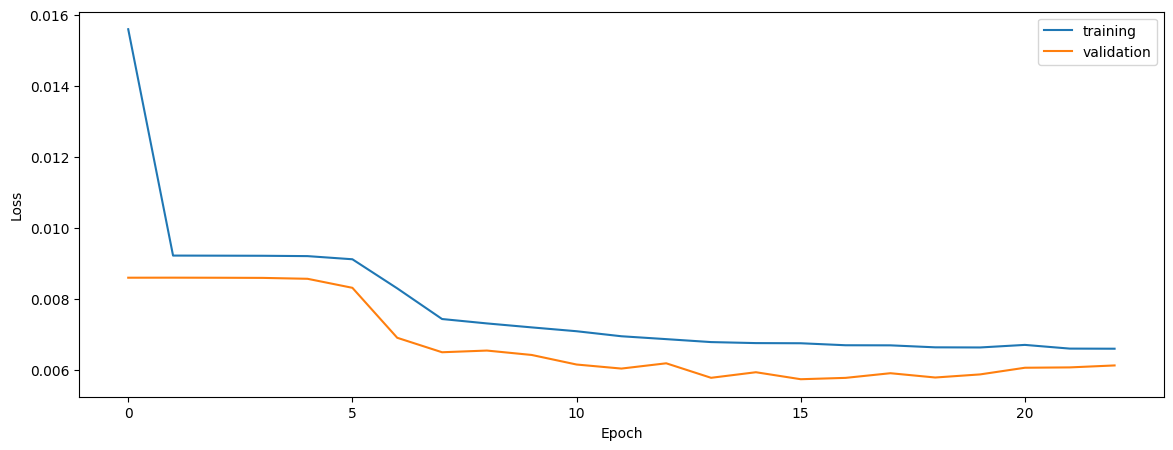

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


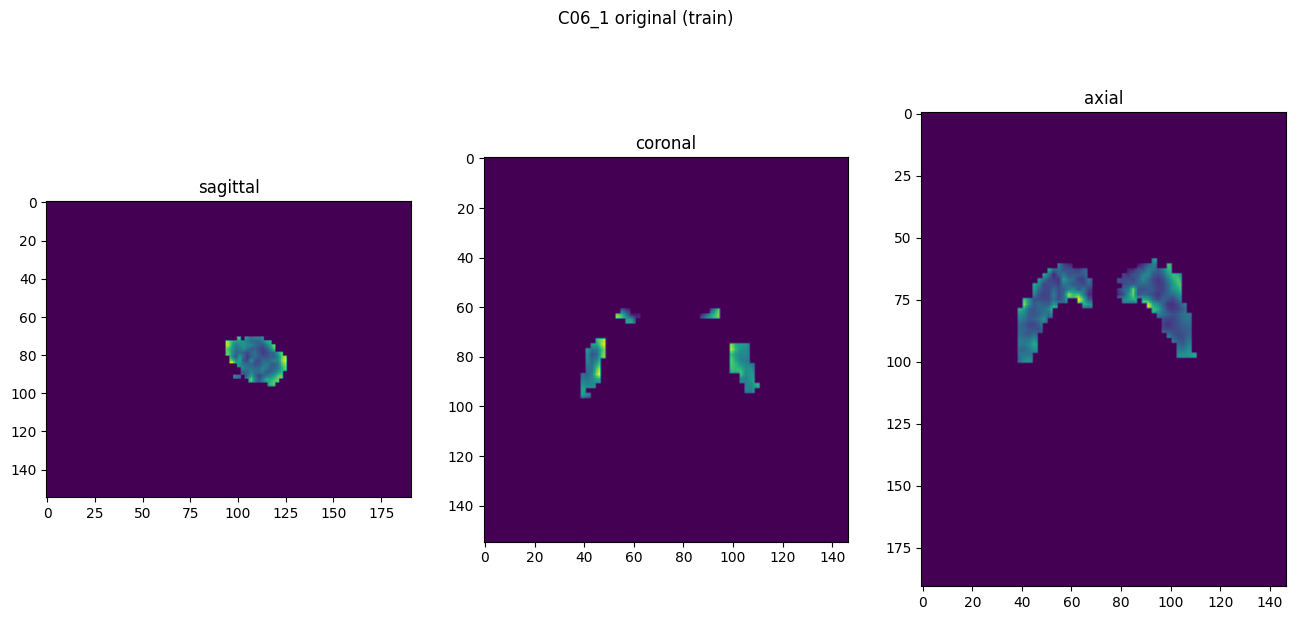

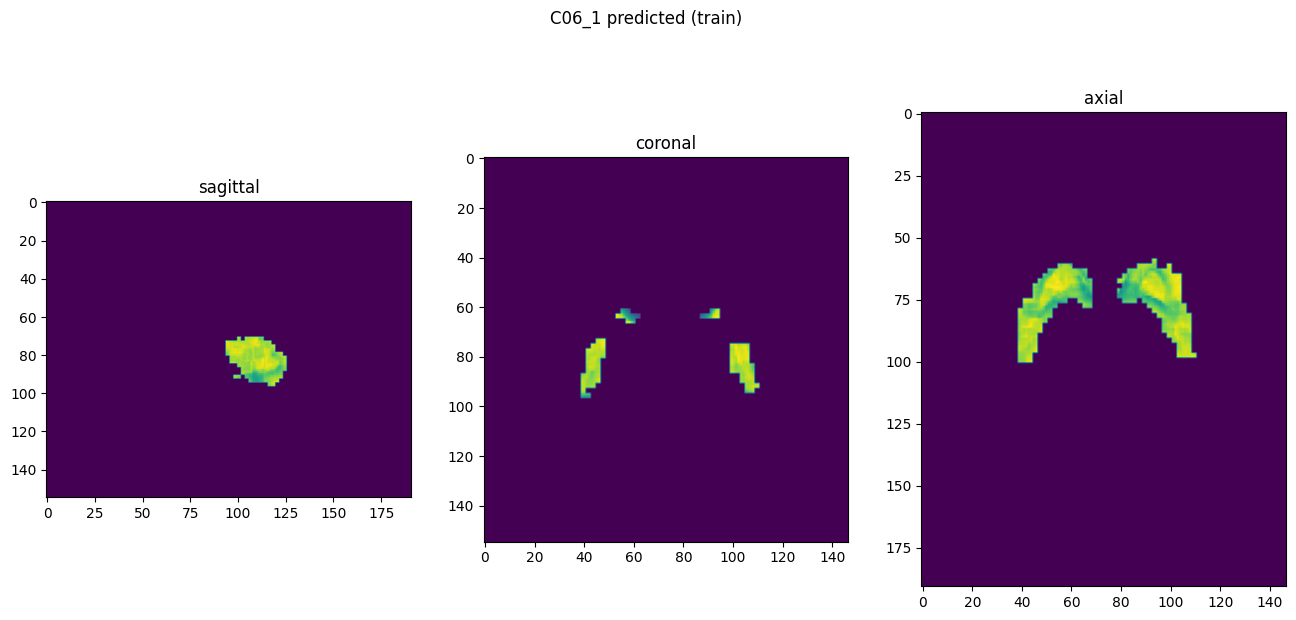

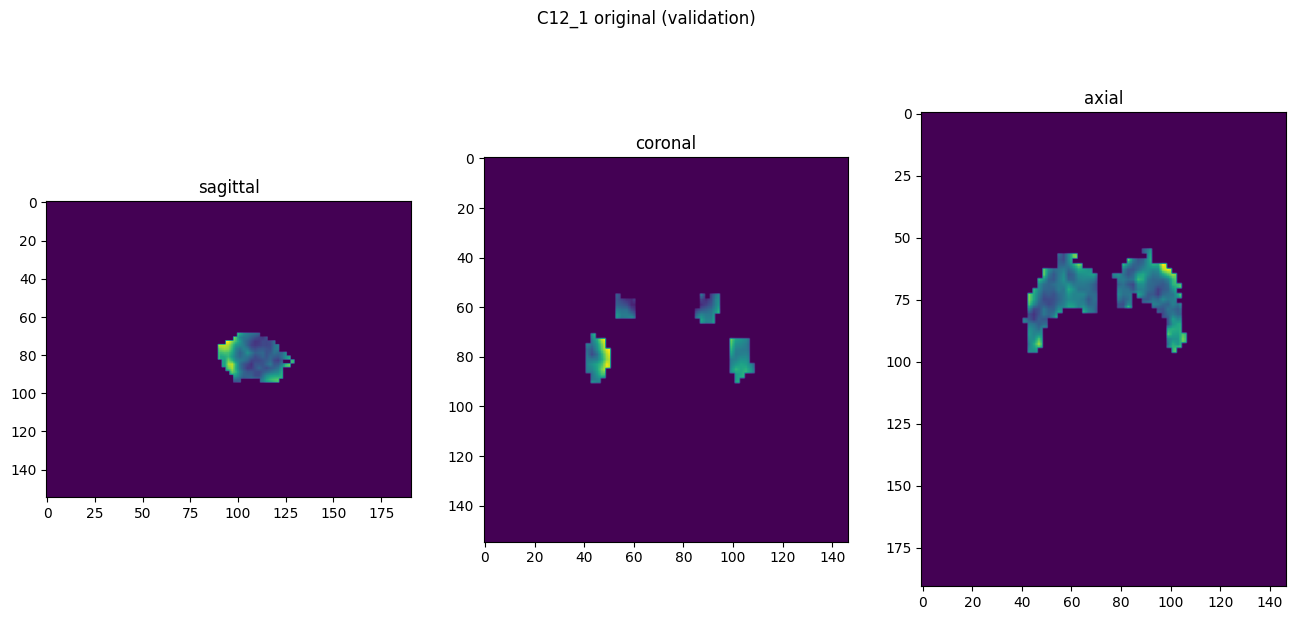

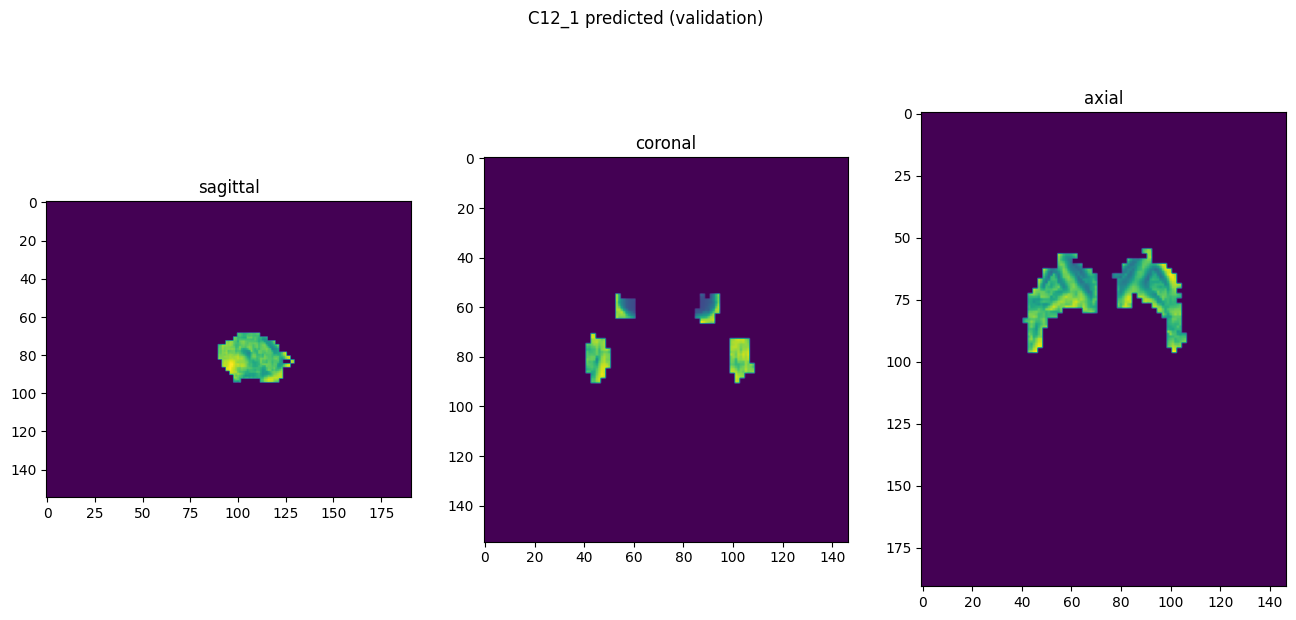

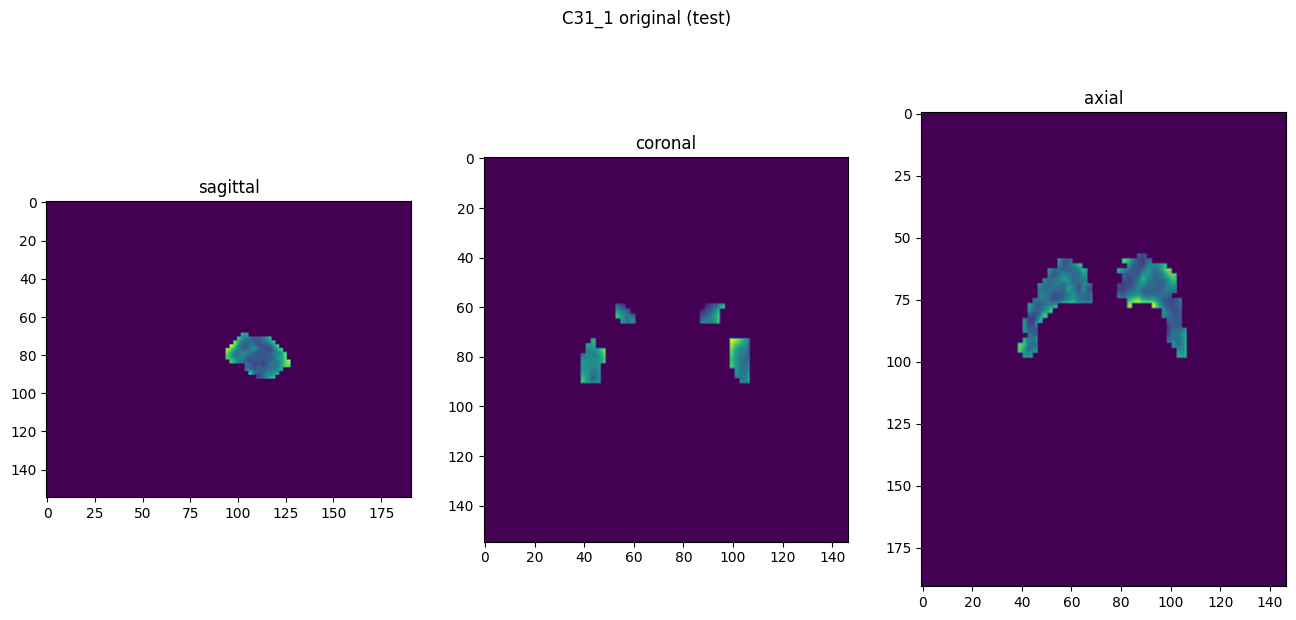

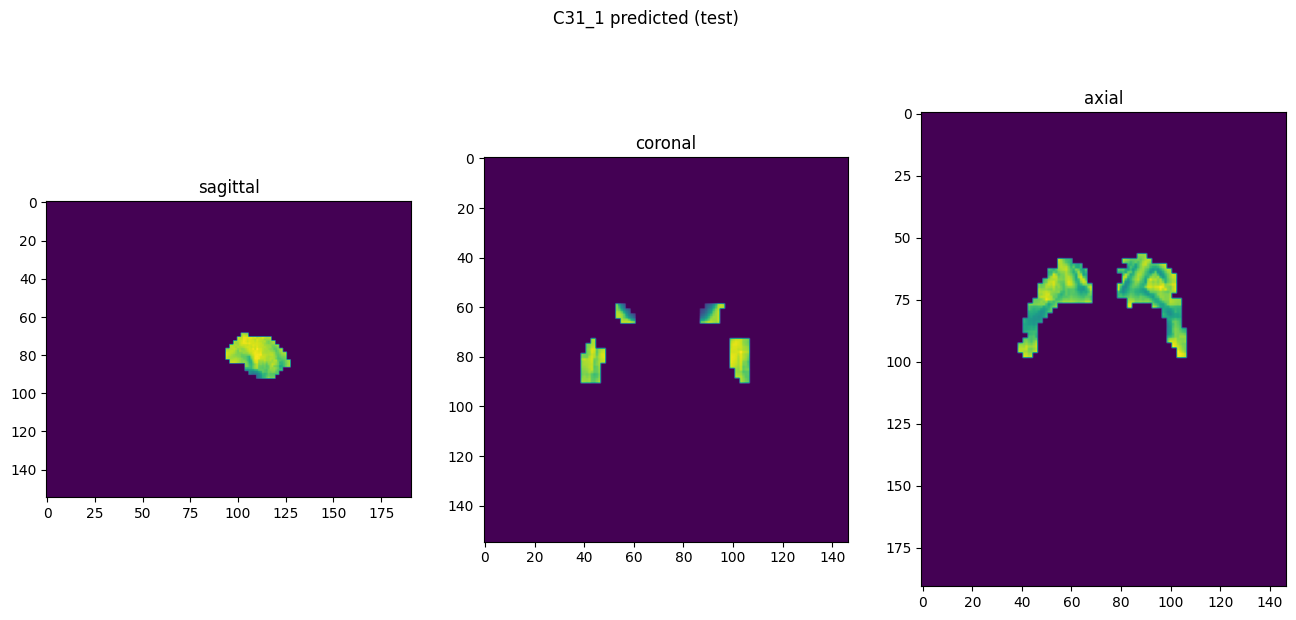

In [10]:
showResults(model, gen, threshold=None, background=False)